In [34]:
import os
import sys
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from datasets import load_metric #huggingface datasets
sys.path.append("../bottlenecks")
%matplotlib inline

import configs
from graph_plot_tools import *
from utils import *
from data_utils import *

In [ ]:
import os
import sys
import torch
import random
import numpy as np
import transformers
import torch.nn as nn
from PIL import Image
from tqdm.auto import tqdm
import torch.nn.functional as F

In [ ]:
configs.set_seed(42)
device = configs.set_device(0)

In [15]:
class SparseCBLmodel_for_logits(nn.Module):
    def __init__(self, num_concepts: int, num_classes: int, model_name: str="openai/clip-vit-base-patch32"):
        super().__init__()
        self.clip = transformers.CLIPModel.from_pretrained(model_name)
        self.processor = transformers.CLIPProcessor.from_pretrained(model_name)
        for param in self.clip.parameters():
            param.requires_grad=False
        self.cbl = nn.Linear(num_concepts, num_concepts, bias=False)
        self.head = nn.Linear(num_concepts, num_classes, bias=False)
        
    def forward(self, **batch):
        cbl_out = self.cbl(self.clip(**batch).logits_per_image)
        return cbl_out, self.head(cbl_out)

In [ ]:
"""datasets"""
# "Andron00e/CIFAR10-custom"
# "Andron00e/CIFAR100-custom"
# "Andron00e/CUB200-custom"
"""concepts"""
# "../data/conceptnet_cifar10_filtered_new.txt"
# "../data/conceptnet_cifar100_filtered_new.txt"
# "../data/conceptnet_places365_filtered_new.txt"
# "../data/conceptnet_imagenet_filtered_new.txt"

In [ ]:
with open("../data/conceptnet_cub200_filtered_new.txt", "r") as f:
    concepts = f.read().split('\n')
    
train_loader_preprocessed  = prepared_dataloaders("Andron00e/CUB200-Custom",
                                                   concepts=concepts,
                                                   prep_loaders="train")

val_loader_preprocessed = prepared_dataloaders("Andron00e/CUB200-Custom",
                                                   concepts=concepts,
                                                   prep_loaders="val")

test_loader_preprocessed = prepared_dataloaders("Andron00e/CUB200-Custom",
                                                   concepts=concepts,
                                                   prep_loaders="test")

In [37]:
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
nets = []


for _ in range(2):
    nets.append(
        SparseCBLmodel_for_logits(num_concepts=len(concepts), num_classes=10)
    )
    nets[-1].zero_grad()
    nets[-1].train()

criterion = nn.CrossEntropyLoss()

In [49]:
opts = []
for i in range(1):
    opts += [
        (optim.Adam(nets[i * 2 + 0].cbl.parameters(), lr=0.001),
         optim.Adam(nets[i * 2 + 0].head.parameters(), lr=0.001)),
        
        (optim.Adam(nets[i * 2 + 1].cbl.parameters(), lr=0.0003), 
         optim.Adam(nets[i * 2 + 1].head.parameters(), lr=0.0003)),
         ]

opt_names = [
    "Adam, 0.001, bs_mul = 1",
    #"AdamW, 0.001, bs_mul = 1",
    "Adam, 0.0003, bs_mul = 1",
] * 1

In [50]:
bs_muls = [
    1, 1,
] * 1

In [31]:
def contrastive_loss(logits, dim: int):
    neg_ce = torch.diag(F.log_softmax(logits, dim=dim))
    return -neg_ce.mean()

def criterion_cbl(similarity: torch.Tensor) -> torch.Tensor:
    """
    Args:
        similarity: is equal to logits_per_image
    """
    caption_loss = contrastive_loss(similarity, dim=0)
    image_loss = contrastive_loss(similarity, dim=1)
    return (caption_loss + image_loss) / 2.0

In [308]:
'''new hist'''
hist = []

for (net, optimizer, opt_name, bs_mul) in zip(nets, opts, opt_names, bs_muls):
    net.to(device)
    hist.append({
        "task_name": "Bottleneck Training",
        "name": opt_name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_cbl_loss": [], "val_cbl_loss": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

In [14]:
lr_decay = 1

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
precision_metric = load_metric('precision')
recall_metric = load_metric('recall')
f1_metric = load_metric('f1')

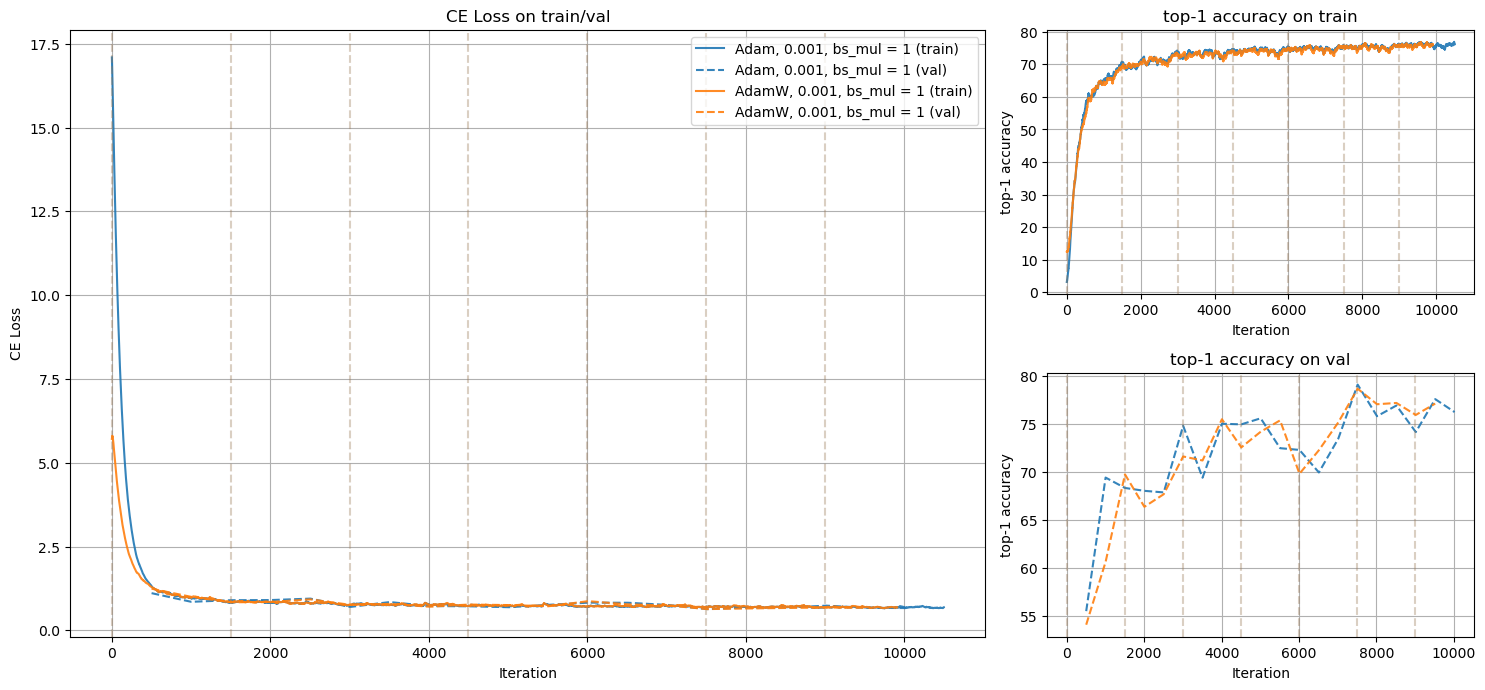

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [310]:
from IPython import display

batch_mul_step_count = 500

norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

loading_path = "BottleneckTraining"
os.makedirs(loading_path, exist_ok=True)

for epoch in range(10):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        
        net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_cbl, optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = net(**inputs)
            cbl_loss = criterion_cbl(cbl_logits)
            cbl_loss.backward(retain_graph=True)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_cbl.step()
                optimizer_cbl.zero_grad()
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_cbl_loss"].append(cbl_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        cbl_logits, logits = net(**inputs)
                        
                        cbl_loss = criterion_cbl(cbl_logits)
                        val_cbl_losses.append(cbl_loss.detach().cpu().item())
                        
                        ce_loss = criterion(logits, targets)
                        val_ce_losses.append(ce_loss.detach().cpu().item())
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                         
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                         references=targets.cpu(), 
                                                         average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                               references=targets.cpu(), 
                                               average='weighted', 
                                               labels=np.unique(logits.argmax(dim=-1).cpu()))
                                               
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))
                net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                               
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                               
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
   
        torch.save({
                "epoch": epoch,
                f'{round(net_hist["val_acc_top_1"][-1], 2)}_model_state_dict': net.state_dict(),
                "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
                "optimizer_head_state_dict": optimizer_head.state_dict(),
                "loss_train": net_hist["train_loss"],
                "cbl_loss_train": net_hist["train_cbl_loss"],
                "loss_val": net_hist["val_loss"],
                "cbl_loss_val": net_hist["val_cbl_loss"],
            }, os.path.join(loading_path, f'{round(net_hist["val_acc_top_1"][-1], 2)}_checkpoint_{epoch}_epoch.pth'))
        
print('Finished Training')

In [311]:
for (net, optimizer, net_hist) in zip(nets, opts, hist):
            net.eval()
            test_top_1_accs, test_top_5_accs = [], []
            test_top_1_precisions, test_top_1_recalls = [], []
            test_top_1_f1scores = []
            with torch.no_grad():
                for step, batch in enumerate(test_loader_preprocessed, 0):
                    inputs, labels = batch
                    inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                    cbl_logits, logits = net(**inputs)
                    top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                    test_top_1_accs.append(top_1.detach().cpu().item())
                    test_top_5_accs.append(top_5.detach().cpu().item())
                    
                    precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                    recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                 references=targets.cpu(), 
                                                 average='weighted')
                    f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                           references=targets.cpu(), 
                                           average='weighted', 
                                           labels=np.unique(logits.argmax(dim=-1).cpu()))
                                           
                    test_top_1_precisions.append(precs['precision'])
                    test_top_1_recalls.append(recs['recall'])
                    test_top_1_f1scores.append(f1['f1'])
            
            net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
            net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))
                                           
            net_hist["test_precision"].append(np.mean(test_top_1_precisions))
            net_hist["test_recall"].append(np.mean(test_top_1_recalls))
            net_hist["test_f1"].append(np.mean(test_top_1_f1scores))
            
            torch.save({
                f'{round(net_hist["test_acc_top_1"][-1], 2)}_model': net.state_dict
                }, os.path.join(loading_path, f'{round(net_hist["test_acc_top_1"][-1], 2)}_model.bin')
            )

In [285]:
def criterion_l1(model, l1_lambda=1e-3):
    """
    Implements L1 regularization
    """
    l1_loss = 0.0
    for param in model.cbl.parameters():
        l1_loss += torch.norm(param, p=1)
        
    return l1_loss * l1_lambda

In [287]:
criterion_l1(nets[0])

tensor(0.6577, device='cuda:0', grad_fn=<MulBackward0>)

In [300]:
hist = []

for (net, optimizer, opt_name, bs_mul) in zip(nets, opts, opt_names, bs_muls):
    net.to(device)
    hist.append({
        "task_name": "L1 BT",
        "name": opt_name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_cbl_loss": [], "val_cbl_loss": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

In [301]:
lr_decay = 0.99

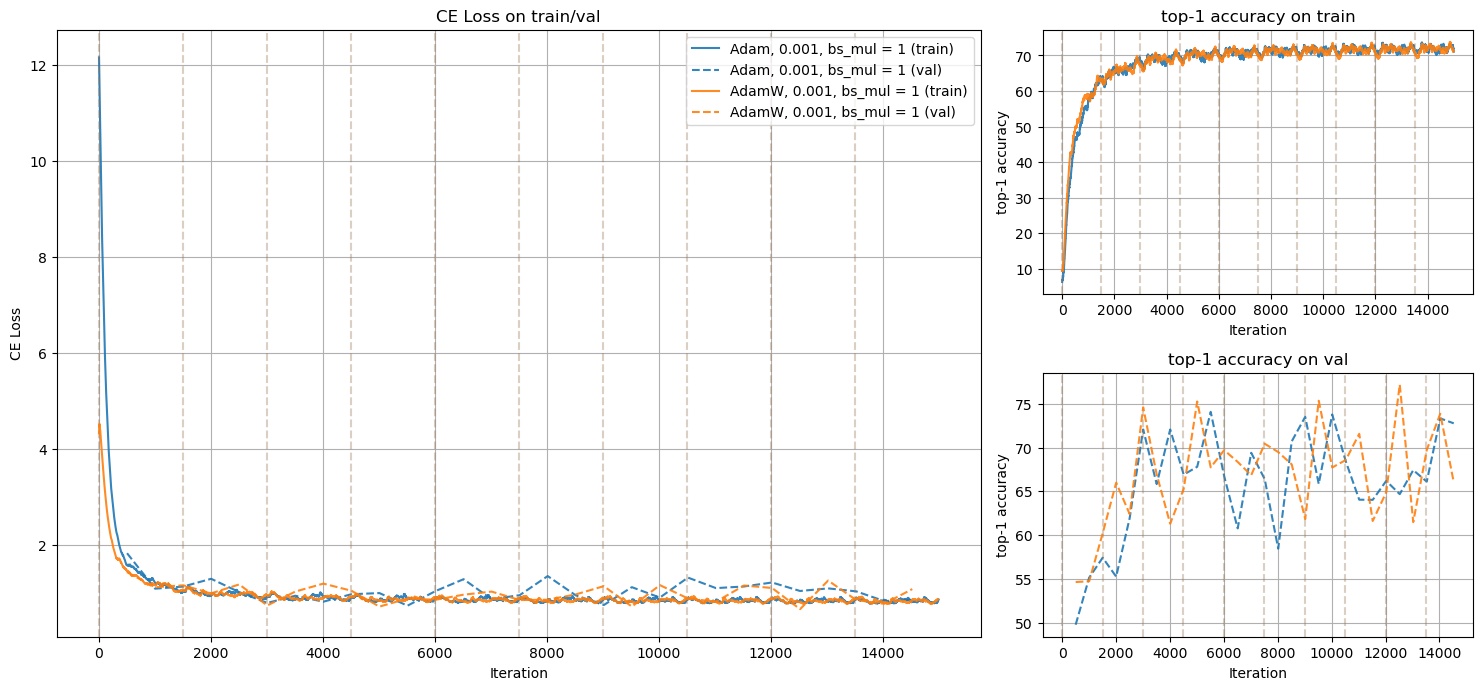

Finished Training


In [302]:
from IPython import display

batch_mul_step_count = 500

norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

loading_path = "L1 BT"
os.makedirs(loading_path, exist_ok=True)

for epoch in range(10):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        
        net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_cbl, optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay

            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = net(**inputs)
            cbl_loss = criterion_l1(net)
            cbl_loss.backward(retain_graph=True)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_cbl.step()
                optimizer_cbl.zero_grad()
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_cbl_loss"].append(cbl_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        cbl_logits, logits = net(**inputs)
                        
                        cbl_loss = criterion_l1(net)
                        val_cbl_losses.append(cbl_loss.detach().cpu().item())
                        
                        ce_loss = criterion(logits, targets)
                        val_ce_losses.append(ce_loss.detach().cpu().item())
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                         
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                         references=targets.cpu(), 
                                                         average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                               references=targets.cpu(), 
                                               average='weighted', 
                                               labels=np.unique(logits.argmax(dim=-1).cpu()))
                                               
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))
                net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                               
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                               
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
   
        torch.save({
                "epoch": epoch,
                f'{round(net_hist["val_acc_top_1"][-1], 2)}_model_state_dict': net.state_dict(),
                "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
                "optimizer_head_state_dict": optimizer_head.state_dict(),
                "loss_train": net_hist["train_loss"],
                "cbl_loss_train": net_hist["train_cbl_loss"],
                "loss_val": net_hist["val_loss"],
                "cbl_loss_val": net_hist["val_cbl_loss"],
            }, os.path.join(loading_path, f'{round(net_hist["val_acc_top_1"][-1], 2)}_checkpoint_{epoch}_epoch.pth'))
        
print('Finished Training')

In [24]:
import torch
import torch.nn.functional as F

def gumbel_contrastive_loss(logits, hard: bool=False, dim: int=0):
    gumbel_softmax_samples = F.gumbel_softmax(logits, tau=1.0, dim=dim, hard=hard)
    neg_ce = -torch.log(gumbel_softmax_samples)
    return neg_ce.mean()

def criterion_gumbel(similarity: torch.Tensor, hard: bool=False) -> torch.Tensor:
    caption_loss = gumbel_contrastive_loss(similarity, hard=hard, dim=0)
    image_loss = gumbel_contrastive_loss(similarity, hard=hard, dim=1)
    return (caption_loss + image_loss) / 2.0

In [51]:
'''new hist'''
hist = []

for (net, optimizer, opt_name, bs_mul) in zip(nets, opts, opt_names, bs_muls):
    net.to(device)
    hist.append({
        "task_name": "Gumble Training",
        "name": opt_name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_cbl_loss": [], "val_cbl_loss": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

hard == False

In [52]:
import warnings
from datasets import load_metric

recall_metric = load_metric('recall')
precision_metric = load_metric('precision')
f1_metric = load_metric('f1')

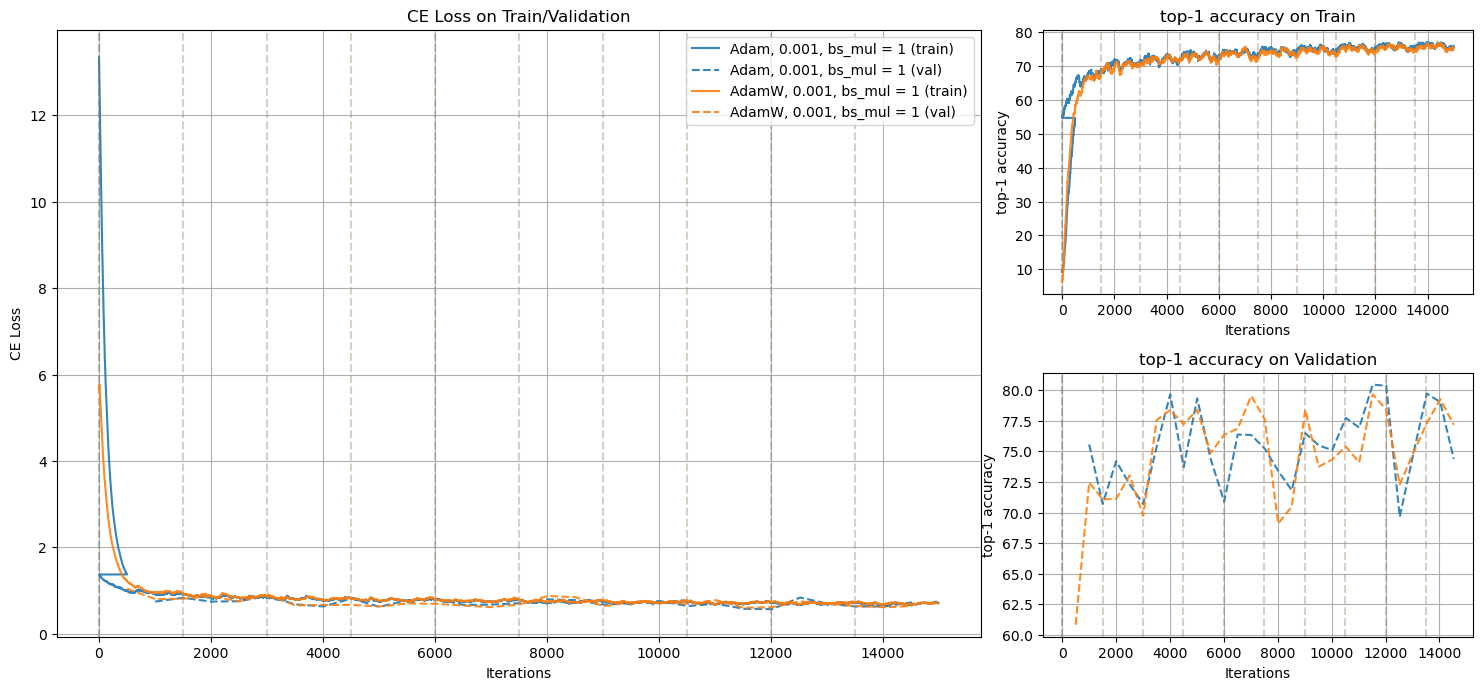

Finished Training


In [20]:
from IPython import display

batch_mul_step_count = 500

norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

loading_path = "Gumble Training"
os.makedirs(loading_path, exist_ok=True)

for epoch in range(10):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        
        net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_cbl, optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay
 
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = net(**inputs)
            cbl_loss = criterion_gumbel(cbl_logits)
            cbl_loss.backward(retain_graph=True)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_cbl.step()
                optimizer_cbl.zero_grad()
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_cbl_loss"].append(cbl_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        cbl_logits, logits = net(**inputs)
                        
                        cbl_loss = criterion_gumbel(cbl_logits)
                        val_cbl_losses.append(cbl_loss.detach().cpu().item())
                        
                        ce_loss = criterion(logits, targets)
                        val_ce_losses.append(ce_loss.detach().cpu().item())
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                         
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                         references=targets.cpu(), 
                                                         average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                               references=targets.cpu(), 
                                               average='weighted', 
                                               labels=np.unique(logits.argmax(dim=-1).cpu()))
                                               
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))
                net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                               
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                               
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
   
        torch.save({
                "epoch": epoch,
                f'{round(net_hist["val_acc_top_1"][-1], 2)}_model_state_dict': net.state_dict(),
                "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
                "optimizer_head_state_dict": optimizer_head.state_dict(),
                "loss_train": net_hist["train_loss"],
                "cbl_loss_train": net_hist["train_cbl_loss"],
                "loss_val": net_hist["val_loss"],
                "cbl_loss_val": net_hist["val_cbl_loss"],
            }, os.path.join(loading_path, f'{round(net_hist["val_acc_top_1"][-1], 2)}_checkpoint_{epoch}_epoch.pth'))
        
print('Finished Training')

In [ ]:
# def test
for (net, optimizer, net_hist) in zip(nets, opts, hist):
            net.eval()
            test_top_1_accs, test_top_5_accs = [], []
            test_top_1_precisions, test_top_1_recalls = [], []
            test_top_1_f1scores = []
            with torch.no_grad():
                warnings.filterwarnings('ignore')
                for step, batch in enumerate(test_loader_preprocessed, 0):
                    inputs, labels = batch
                    inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                    cbl_logits, logits = net(**inputs)
                    top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                    test_top_1_accs.append(top_1.detach().cpu().item())
                    test_top_5_accs.append(top_5.detach().cpu().item())
                    
                    precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                    recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                 references=targets.cpu(), 
                                                 average='weighted')
                    f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                           references=targets.cpu(), 
                                           average='weighted', 
                                           labels=np.unique(logits.argmax(dim=-1).cpu()))
                                           
                    test_top_1_precisions.append(precs['precision'])
                    test_top_1_recalls.append(recs['recall'])
                    test_top_1_f1scores.append(f1['f1'])
            
            net_hist["test_acc_top_1"].append(np.mean(test_top_1_accs))
            net_hist["test_acc_top_5"].append(np.mean(test_top_5_accs))
                                           
            net_hist["test_precision"].append(np.mean(test_top_1_precisions))
            net_hist["test_recall"].append(np.mean(test_top_1_recalls))
            net_hist["test_f1"].append(np.mean(test_top_1_f1scores))
            
            torch.save({
                f'{round(net_hist["test_acc_top_1"][-1], 2)}_model': net.state_dict
                }, os.path.join(loading_path, f'{round(net_hist["test_acc_top_1"][-1], 2)}_model.bin')
            )

## biggest model

In [37]:
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
nets = []


for _ in range(2):
    nets.append(
        SparseCBLmodel_for_logits(num_concepts=len(concepts), num_classes=100, model_name="openai/clip-vit-large-patch14")
    )
    nets[-1].zero_grad()
    nets[-1].train()

criterion = nn.CrossEntropyLoss()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [38]:
print("Number of parameters: ", sum(p.numel() for p in nets[0].parameters()), "\n")
print("Number of trainable parameters: ", sum(p.numel() for p in nets[0].parameters() if p.requires_grad == True), "\n")

Number of parameters:  428602049 

Number of trainable parameters:  985536 



In [50]:
'''new hist'''
hist = []

for (net, optimizer, opt_name, bs_mul) in zip(nets, opts, opt_names, bs_muls):
    net.to(device)
    hist.append({
        "task_name": "Gumble Training",
        "name": opt_name,
        "bs_mul": bs_mul,
        "train_loss": [], "train_x": [],
        "val_loss": [], "val_x": [],
        "train_cbl_loss": [], "val_cbl_loss": [],
        "train_acc_top_1": [], "train_acc_top_5": [],
        "test_acc_top_1": [], "test_acc_top_5": [],
        "val_acc_top_1": [], "val_acc_top_5": [],
        "val_precision": [], "val_recall": [],
        "val_f1": [], "test_precision": [],
        "test_recall": [], "test_f1": [],
        "norm_diffs": [],
        "epochs_x": [],
        "norm_diffs_x": [],
        "total_steps": 0,
        "prev_val_eval_step": 0,
        "prev_grad_norms_eval_step": 0,
        "batch_end": True
    })

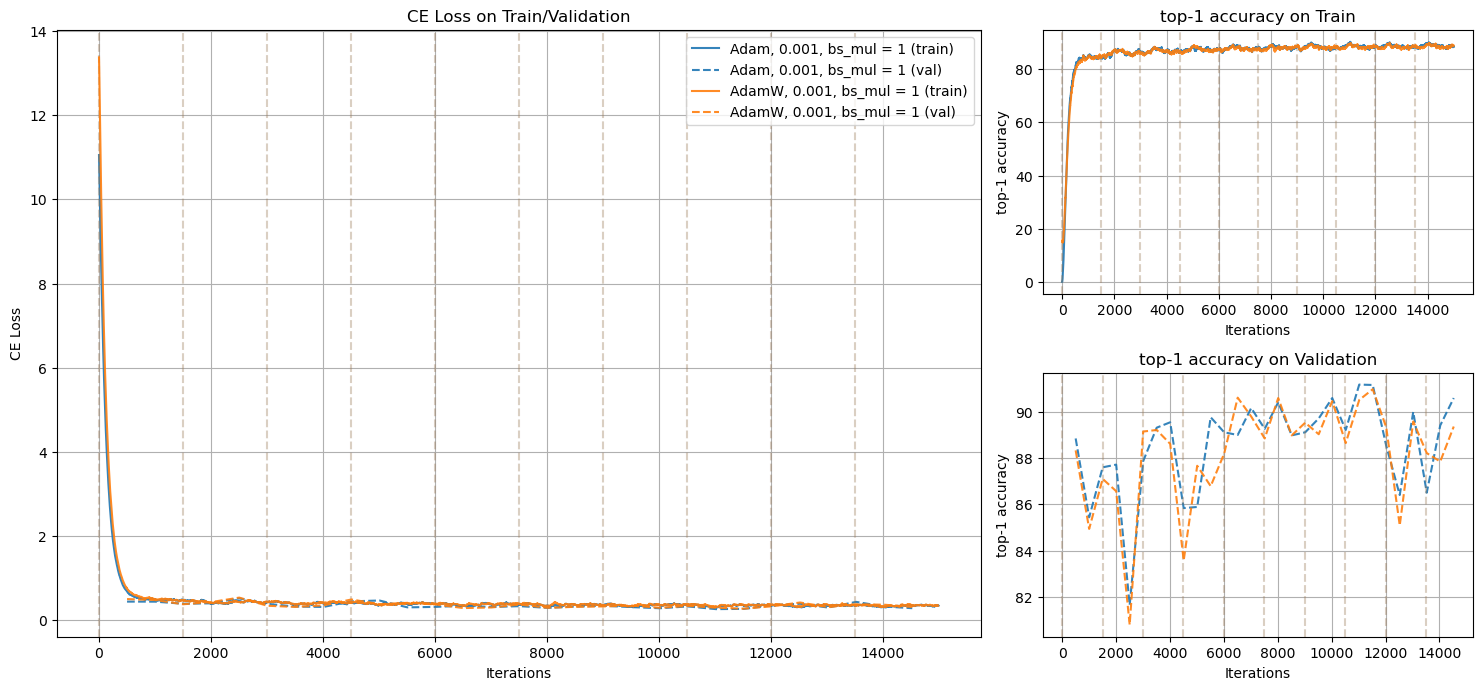

Finished Training


In [56]:
from IPython import display

batch_mul_step_count = 500

norm_diffs_step_count = 500
val_step_count = 500
calc_norm_diffs = False

loading_path = "Gumble Training"
os.makedirs(loading_path, exist_ok=True)

for epoch in range(10):
    for (net, optimizer, net_hist) in zip(nets, opts, hist):
        
        net.to(device)
        total_steps = net_hist["total_steps"]
        bs_mul = net_hist["bs_mul"]

        if net_hist["bs_mul"] == "linear":
            if not ("bs_mul_value" in net_hist):
                net_hist["bs_mul_value"] = 1

            bs_mul = net_hist["bs_mul_value"]

        net_hist["epochs_x"].append(total_steps)
        optimizer_cbl, optimizer_head = optimizer

        for i, data in enumerate(train_loader_preprocessed, 0):

            prev_grad_norms_eval_step = net_hist["prev_grad_norms_eval_step"]
            if calc_norm_diffs and ((total_steps - prev_grad_norms_eval_step) > norm_diffs_step_count or
                                    len(net_hist["norm_diffs"]) == 0) and net_hist["batch_end"]:
                net_hist["prev_grad_norms_eval_step"] = total_steps
                net.eval()

                norm_diffs = compute_norm_diffs(
                    net, optimizer_head, None,
                    train_loader_wo_crops, train_loader_wo_crops, repeats=5
                )

                net_hist["norm_diffs"].append(norm_diffs)
                net_hist["norm_diffs_x"].append(total_steps)
                net.train()

            net_hist["batch_end"] = False

            if lr_decay < 1:
                for g in optimizer_head.param_groups:
                    g['lr'] = g['lr'] * lr_decay

            
            inputs, labels = data
            inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
            cbl_logits, logits = net(**inputs)
            cbl_loss = criterion_gumbel(cbl_logits)
            cbl_loss.backward(retain_graph=True)
            ce_loss = criterion(logits, targets) / bs_mul
            ce_loss.backward()

            if total_steps % bs_mul == bs_mul - 1:
                optimizer_cbl.step()
                optimizer_cbl.zero_grad()
                optimizer_head.step()
                optimizer_head.zero_grad()
                net_hist["batch_end"] = True

            net_hist["train_loss"].append(ce_loss.detach().cpu().item() * bs_mul)
            net_hist["train_cbl_loss"].append(cbl_loss.detach().cpu().item() * bs_mul)
            net_hist["train_x"].append(total_steps)

            if total_steps % bs_mul == bs_mul - 1:
                if net_hist["bs_mul"] == "linear":
                    net_hist["bs_mul_value"] = int(int(total_steps) / batch_mul_step_count) + 1
                    bs_mul = net_hist["bs_mul_value"]

            top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
            net_hist["train_acc_top_1"].append(top_1.detach().cpu().item())
            net_hist["train_acc_top_5"].append(top_5.detach().cpu().item())

            prev_val_eval_step = net_hist["prev_val_eval_step"]
            if (total_steps - prev_val_eval_step) > val_step_count and net_hist["batch_end"]:
                net_hist["prev_val_eval_step"] = total_steps

                net.eval()

                val_cbl_losses = []
                val_ce_losses = []
                val_top_1_accs = []
                val_top_5_accs = []
                val_top_1_precisions = []
                val_top_1_recalls = []
                val_top_1_f1scores = []

                with torch.no_grad():
                    for step, val_data in enumerate(val_loader_preprocessed):

                        inputs, labels = val_data
                        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
                        cbl_logits, logits = net(**inputs)
                        
                        cbl_loss = criterion_gumbel(cbl_logits)
                        val_cbl_losses.append(cbl_loss.detach().cpu().item())
                        
                        ce_loss = criterion(logits, targets)
                        val_ce_losses.append(ce_loss.detach().cpu().item())
                        
                        top_1, top_5 = accuracy(logits, targets, topk=(1, 5))
                        val_top_1_accs.append(top_1.detach().cpu().item())
                        val_top_5_accs.append(top_5.detach().cpu().item())
                         
                        precs = precision_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                         references=targets.cpu(), 
                                                         average='weighted')
                        recs = recall_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                                     references=targets.cpu(), 
                                                     average='weighted')
                        f1 = f1_metric.compute(predictions=logits.argmax(dim=-1).cpu(), 
                                               references=targets.cpu(), 
                                               average='weighted', 
                                               labels=np.unique(logits.argmax(dim=-1).cpu()))
                                               
                        val_top_1_precisions.append(precs['precision'])
                        val_top_1_recalls.append(recs['recall'])
                        val_top_1_f1scores.append(f1['f1'])

                net_hist["val_loss"].append(np.mean(val_ce_losses))
                net_hist["val_cbl_loss"].append(np.mean(val_cbl_losses))

                net_hist["val_acc_top_1"].append(np.mean(val_top_1_accs))
                net_hist["val_acc_top_5"].append(np.mean(val_top_5_accs))
                                               
                net_hist["val_precision"].append(np.mean(val_top_1_precisions))
                net_hist["val_recall"].append(np.mean(val_top_1_recalls))
                net_hist["val_f1"].append(np.mean(val_top_1_f1scores))
                                               
                net_hist["val_x"].append(total_steps)
                net.train()

            if total_steps % 10 == 0:
                display.clear_output(wait=True)

                grouped_hist = group_uniques_full(hist, ["train_loss", "val_loss", "val_acc_top_1", "train_acc_top_1"])

                fig = plt.figure(figsize=(15, 8 + 2 * ((len(grouped_hist) + 2) // 3)))
                gs = GridSpec(4 + 2 * ((len(grouped_hist) + 2) // 3),3, figure=fig)

                ax1 = fig.add_subplot(gs[0:4,:2])
                ax2 = fig.add_subplot(gs[0:2,2])
                ax3 = fig.add_subplot(gs[2:4,2])

                ax1 = make_loss_plot(
                    ax1, grouped_hist, loss_name = "CE Loss", eps=0.01,
                    make_val=True, alpha=0.9) #False
                ax2 = make_accuracy_plot(
                    ax2, grouped_hist, eps=0.01,
                    make_train=True, make_val=False, top_k=1, alpha=0.9)
                ax3 = make_accuracy_plot(
                    ax3, grouped_hist, eps=0.01,
                    make_train=False, make_val=True, top_k=1, alpha=0.9)

                if calc_norm_diffs:
                    draw_norm_hists_for_different_models(fig, gs[4:,:], grouped_hist, bins_n=100, draw_normal=True)

                gs.tight_layout(fig)
                plt.draw()
                plt.show()

            total_steps += 1
        net_hist["total_steps"] = total_steps
   
        torch.save({
                "epoch": epoch,
                f'{round(net_hist["val_acc_top_1"][-1], 2)}_model_state_dict': net.state_dict(),
                "optimizer_cbl_state_dict": optimizer_cbl.state_dict(),
                "optimizer_head_state_dict": optimizer_head.state_dict(),
                "loss_train": net_hist["train_loss"],
                "cbl_loss_train": net_hist["train_cbl_loss"],
                "loss_val": net_hist["val_loss"],
                "cbl_loss_val": net_hist["val_cbl_loss"],
            }, os.path.join(loading_path, f'{round(net_hist["val_acc_top_1"][-1], 2)}_checkpoint_{epoch}_epoch.pth'))
        
print('Finished Training')